In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from Bio.PDB import MMCIFParser, FastMMCIFParser
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
from Bio.PDB.DSSP import DSSP
from Bio.PDB import PDBList
from Bio.SeqUtils import IUPACData

from loop.pdb_files import get_PDBfiles, parse_mmcif
from loop.dssp import generate_pdp_chain_pairs
from utils.common import load_tab, save_tab, dump_dicts2jsons, lower_pdbid, read_json2dict, dump_dict2json
from utils.protein import protein_letters_3to1

from utils.loops import print_loop_count

from domain_linker.cc_contact import contact, getCoords
from domain_linker.extract_linkers import get_2domain_start_end
from domain_linker.hbond import check_2Hbond
from params import *

from utils.log import logger

# Functions

In [2]:
def clasify_interDomainLinker(df_domain_loops_dist, t_contact: int, t_hbond: int):
    '''
    classify domain-linkers from inter-domain loops. Between two domains:
    1. Num(C-C contact) < t_contact
    2. Num(Hbond) < t_hbond
    '''
    df_contact_t = df_domain_loops_dist[df_domain_loops_dist['num_contacts']<t_contact]
    df_independent = df_contact_t[df_contact_t['num_hbonds']<t_hbond]
    idx_independent = list(df_independent['linkerID'])
    idx_dependent = list(set(df_domain_loops_dist['linkerID']) - set(df_independent['linkerID']))
    df_dependent = df_domain_loops_dist[df_domain_loops_dist['linkerID'].isin(idx_dependent)]
    
    return df_independent, df_dependent, df_contact_t

In [3]:
def bin_count(df_independent, bins: list):
    loop_length = list(df_independent['length'])
    
    cls = [np.round(np.random.rand(),1), np.round(np.random.rand(),1),np.round(np.random.rand(),1), 0.8]
    print(cls)
    plt.figure(figsize=(12, 6))
    counts, edges, bars = plt.hist(loop_length, bins=bins, color=cls)
    
    return counts, loop_length, edges

# generate intraDomainLoops table -- skippable

In [5]:
loops_smoothSS_first = read_json2dict(path_loops_all_smoothSS_first)
loops_smoothSS_second = read_json2dict(path_loops_all_smoothSS_second)

len(loops_smoothSS_first.keys()), len(loops_smoothSS_second.keys())

(2649, 2649)

In [6]:
loops_intra_domain_2step = read_json2dict(path_loops_intra_domain_smoothSS_first_2step)
len(loops_intra_domain_2step.keys())

2649

In [7]:
'''
df_domain_loops_dist_smoothSS_second = load_tab(path_loops_domain_dist_hbond_contact_smoothSS_second)

t_contact = 4
t_hbond = 3

df_independent_2step, df_dependent_2step, df_contact_t_2step = clasify_interDomainLinker(df_domain_loops_dist_smoothSS_second, t_contact, t_hbond)
'''

'\ndf_domain_loops_dist_smoothSS_second = load_tab(path_loops_domain_dist_hbond_contact_smoothSS_second)\n\nt_contact = 4\nt_hbond = 3\n\ndf_independent_2step, df_dependent_2step, df_contact_t_2step = clasify_interDomainLinker(df_domain_loops_dist_smoothSS_second, t_contact, t_hbond)\n'

In [8]:
# loops_intra_domain_2step

In [9]:
df_intraDomainLoops = pd.DataFrame()

for pdb_chainid, loops in loops_intra_domain_2step.items():
    df_loops = pd.json_normalize(loops)
    df_loops['pdbid'] = pdb_chainid.split('_')[0].upper()
    df_loops['chain'] = pdb_chainid.split('_')[1].upper()
    df_intraDomainLoops = pd.concat([df_intraDomainLoops, df_loops], axis=0, ignore_index=True)

In [10]:
df_intraDomainLoops.shape[0]

45403

In [12]:
df_intraDomainLoops['seq'] = [' '.join(seq) for seq in df_intraDomainLoops['seq']]
df_intraDomainLoops['seq_unp'] = [' '.join(seq) for seq in df_intraDomainLoops['seq_unp']]

In [13]:
save_tab(df_intraDomainLoops, path_loops_intra_domain_smoothSS_first_2step_tab)

# Plots

In [3]:
df_intraDomainLoops = load_tab(path_loops_intra_domain_smoothSS_first_2step_tab)
df_intraDomainLoops.shape

(45829, 17)

In [27]:
df_intraDomainLoops.sort_values(by='length', ascending=False)

,start,end,seq_id,start_unp,end_unp,seq_id_unp,seq,seq_unp,dssp_key_str,missing,miss_length,miss_percentage,unp_acc,length,domain,pdbid,chain
42684,459.0,576.0,"[459, 460, 461, 462, 463, 464, 465, 466, 467, ...",459.0,576.0,"[459, 460, 461, 462, 463, 464, 465, 466, 467, ...",D V V Y S D H C F S V N S D F C P C A D P S V ...,D V V Y S D H C F S V N S D F C P C A D P S V ...,"['A_459_ ', 'A_460_ ', 'A_461_ ', 'A_462_ ', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",95.0,0.805085,Q0ZME7,118.0,8091055.0,5I08,A
41258,236.0,347.0,"[236, 237, 238, 239, 240, 241, 242, 243, 244, ...",236.0,347.0,"[236, 237, 238, 239, 240, 241, 242, 243, 244, ...",T Q Q L G M R L V L D G V F N H S G D S H A W ...,T Q Q L G M R L V L D G V F N H S G D S H A W ...,"['A_236_ ', 'A_237_ ', 'A_238_ ', 'A_239_ ', '...","[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.0,0.044643,P21517,112.0,8098575.0,5BN7,A
20325,46.0,152.0,"[46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 5...",45.0,151.0,"[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 5...",A S Y D L P P F D R A A V D G Y A V R A E D T ...,A S Y D L P P F D R A A V D G Y A V R A E D T ...,"['A_46_ ', 'A_47_ ', 'A_48_ ', 'A_49_ ', 'A_50...","[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",91.0,0.850467,Q8U034,107.0,8031547.0,1XI8,A
42369,401.0,499.0,"[401, 402, 403, 404, 405, 406, 407, 408, 409, ...",401.0,499.0,"[401, 402, 403, 404, 405, 406, 407, 408, 409, ...",N N P N D I A I L N D Y L S A Y L Q G N K N S ...,N N P N D I A I L N D Y L S A Y L Q G N K N S ...,"['A_401_ ', 'A_402_ ', 'A_403_ ', 'A_404_ ', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...",87.0,0.878788,P04331,99.0,8093077.0,5FB4,A
43547,592.0,686.0,"[592, 593, 594, 595, 596, 597, 598, 599, 600, ...",581.0,675.0,"[581, 582, 583, 584, 585, 586, 587, 588, 589, ...",A N P K I A C I E C N D I P V I Y G E T K D K ...,A N P K I A C I E C N D I P V I Y G E T K D K ...,"['A_592_ ', 'A_593_ ', 'A_594_ ', 'A_595_ ', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",55.0,0.578947,P31776,95.0,8101873.0,5U2G,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32638,38.0,41.0,"[38, 39, 40, 41]",38.0,41.0,"[38, 39, 40, 41]",L A E P,L A E P,"['A_38_ ', 'A_39_ ', 'A_40_ ', 'A_41_ ']","[0, 0, 0, 0]",0.0,0.000000,Q8YNT0,4.0,8017932.0,3IGF,A
32637,29.0,32.0,"[29, 30, 31, 32]",29.0,32.0,"[29, 30, 31, 32]",Q G K R,Q G K R,"['A_29_ ', 'A_30_ ', 'A_31_ ', 'A_32_ ']","[0, 0, 0, 0]",0.0,0.000000,Q8YNT0,4.0,8017932.0,3IGF,A
14411,294.0,297.0,"[294, 295, 296, 297]",294.0,297.0,"[294, 295, 296, 297]",T G S F,T G S F,"['A_294_ ', 'A_295_ ', 'A_296_ ', 'A_297_ ']","[0, 0, 0, 0]",0.0,0.000000,P06169,4.0,8031870.0,1QPB,A
38276,167.0,170.0,"[167, 168, 169, 170]",167.0,170.0,"[167, 168, 169, 170]",L E L N,L E L N,"['A_167_ ', 'A_168_ ', 'A_169_ ', 'A_170_ ']","[0, 0, 0, 0]",0.0,0.000000,P40064,4.0,8051250.0,4MHC,A


In [38]:
multi_domain = load_tab(path_tab_scop_FA_continuous_uni_multi_parse_domian)
multi_domain[multi_domain['FA-PDBID']=='1TF4']

,FA-DOMID,FA-PDBID,FA-PDBREG,FA-UNIID,FA-UNIREG,FA,FA-UNIREG-START,FA-UNIREG-END,FA-PDBREG-START,FA-PDBREG-END,FA-CHAINID
2364,8025992,1TF4,A:1-460,P26221,47-506,4001168,47,506,1,460,A
2365,8027810,1TF4,A:461-605,P26221,507-651,4002028,507,651,461,605,A


## All

In [13]:
length =  df_intraDomainLoops['length']
max(length), min(length)

(118.0, 4.0)

[0.4, 0.3, 0.7, 0.8]


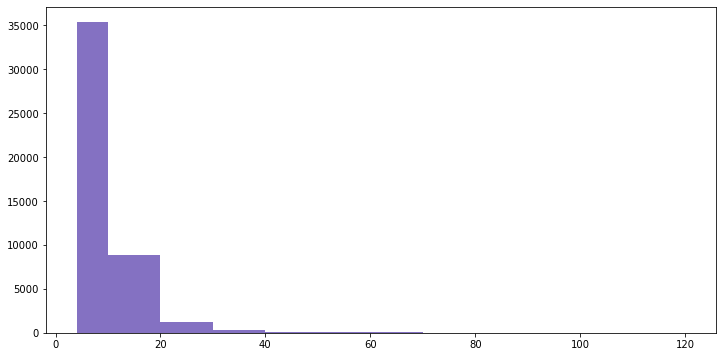

In [14]:
bins = [4, 10, 20, 30, 40, 50, 70, 100, 120]
counts_intra, length_intra, _ = bin_count(df_intraDomainLoops, bins)

Text(0, 0.5, 'Length of Loop')

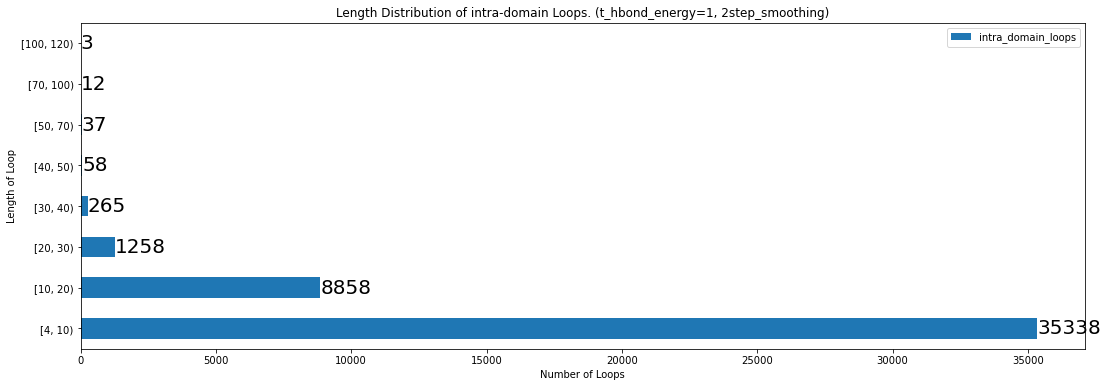

In [15]:
x = [u'[4, 10)', u'[10, 20)', u'[20, 30)', u'[30, 40)', u'[40, 50)', u'[50, 70)', u'[70, 100)', u'[100, 120)']
y = counts_intra

# index = ['snail', 'pig', 'elephant','rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'intra_domain_loops': y})
df = df.set_axis(x)
ax = df.plot.barh(figsize=(18,6))
# ax.axhline(0, color='grey', linewidth=0.8)
ax.bar_label(ax.containers[0], fontsize=20)

ax.set_title('Length Distribution of intra-domain Loops. (t_hbond_energy=1, 2step_smoothing)')
ax.set_xlabel('Number of Loops')
ax.set_ylabel('Length of Loop')

## Length>=40

In [79]:
df_intraDomainLoops_40 = df_intraDomainLoops[df_intraDomainLoops['length']>=40]

[0.1, 0.6, 0.6, 0.8]


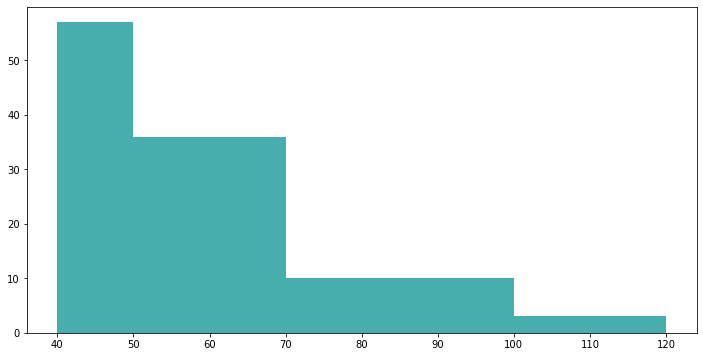

In [80]:
bins = [40, 50, 70, 100, 120]
counts_intra, length_intra, _ = bin_count(df_intraDomainLoops, bins)

In [85]:
df_intraDomainLoops_40_50 = df_intraDomainLoops_40[df_intraDomainLoops_40['length']<50]
df_intraDomainLoops_50_70 = df_intraDomainLoops_40[(df_intraDomainLoops_40['length']>=50) & (df_intraDomainLoops_40['length']<70)]
df_intraDomainLoops_70_100 = df_intraDomainLoops_40[(df_intraDomainLoops_40['length']>=70) & (df_intraDomainLoops_40['length']<100)]
df_intraDomainLoops_100_120 = df_intraDomainLoops_40[(df_intraDomainLoops_40['length']>=100) & (df_intraDomainLoops_40['length']<120)]

list_4bins = [df_intraDomainLoops_40_50, df_intraDomainLoops_50_70, df_intraDomainLoops_70_100, df_intraDomainLoops_100_120]

counts_missing = [df_loops[df_loops['miss_percentage']>=0.5].shape[0] for df_loops in list_4bins]

Text(0, 0.5, 'Length of Loop')

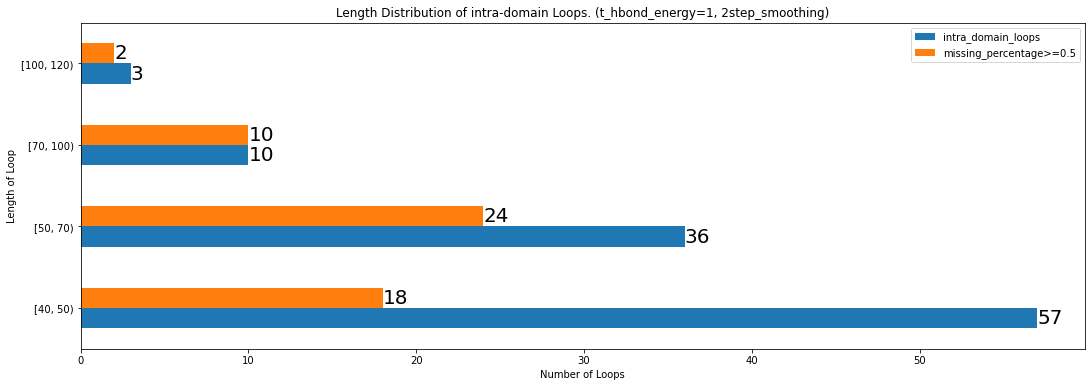

In [86]:
x = [u'[40, 50)', u'[50, 70)', u'[70, 100)', u'[100, 120)']
y = counts_intra
y_missing = counts_missing

# index = ['snail', 'pig', 'elephant','rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'intra_domain_loops': y, 'missing_percentage>=0.5': y_missing})
df = df.set_axis(x)
ax = df.plot.barh(figsize=(18,6))
# ax.axhline(0, color='grey', linewidth=0.8)
ax.bar_label(ax.containers[0], fontsize=20)
ax.bar_label(ax.containers[1], fontsize=20)

ax.set_title('Length Distribution of intra-domain Loops. (t_hbond_energy=1, 2step_smoothing)')
ax.set_xlabel('Number of Loops')
ax.set_ylabel('Length of Loop')

In [ ]:
df_intraDomainLoops_40_50[df_intraDomainLoops_40_50['miss_percentage']==0]

In [83]:
df_intraDomainLoops_50_70[df_intraDomainLoops_50_70['miss_length']==0]

,start,end,start_unp,end_unp,seq,seq_unp,dssp_key_str,missing,miss_length,miss_percentage,unp_acc,length,pdbid,chain
901,84.0,136.0,110.0,162.0,"['P', 'N', 'W', 'P', 'Y', 'A', 'S', 'N', 'W', ...","['P', 'N', 'W', 'P', 'Y', 'A', 'S', 'N', 'W', ...","['A_84_ ', 'A_85_ ', 'A_86_ ', 'A_87_ ', 'A_88...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,P10342,53.0,1BF2,A
7143,164.0,223.0,164.0,223.0,"['M', 'G', 'F', 'K', 'T', 'F', 'G', 'Y', 'A', ...","['M', 'G', 'F', 'K', 'T', 'F', 'G', 'Y', 'A', ...","['B_164_ ', 'B_165_ ', 'B_166_ ', 'B_167_ ', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,O59651,60.0,1ITK,B
8227,487.0,541.0,506.0,560.0,"['F', 'S', 'Q', 'S', 'C', 'A', 'P', 'G', 'A', ...","['F', 'S', 'Q', 'S', 'C', 'A', 'P', 'G', 'A', ...","['A_487_ ', 'A_488_ ', 'A_489_ ', 'A_490_ ', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,Q29477,55.0,1JW1,A
15276,715.0,767.0,715.0,767.0,"['L', 'G', 'R', 'N', 'A', 'M', 'D', 'Q', 'S', ...","['L', 'G', 'R', 'N', 'A', 'M', 'D', 'Q', 'S', ...","['A_715_ ', 'A_716_ ', 'A_717_ ', 'A_718_ ', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,Q59325,53.0,1RQ5,A
17959,716.0,767.0,510.0,561.0,"['G', 'R', 'N', 'A', 'M', 'D', 'Q', 'S', 'Y', ...","['G', 'R', 'N', 'A', 'M', 'D', 'Q', 'S', 'Y', ...","['A_716_ ', 'A_717_ ', 'A_718_ ', 'A_719_ ', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,Q6RSN8,52.0,1UT9,A
23537,1169.0,1219.0,1169.0,1219.0,"['T', 'N', 'I', 'F', 'E', 'S', 'F', 'A', 'P', ...","['T', 'N', 'I', 'F', 'E', 'S', 'F', 'A', 'P', ...","['A_1169_ ', 'A_1170_ ', 'A_1171_ ', 'A_1172_ ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,P94692,51.0,2C42,A
29618,371.0,428.0,370.0,427.0,"['R', 'P', 'R', 'A', 'P', 'I', 'H', 'N', 'N', ...","['R', 'P', 'R', 'A', 'P', 'I', 'H', 'N', 'N', ...","['E_371_ ', 'E_372_ ', 'E_373_ ', 'E_374_ ', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,D9N167,58.0,2XF2,E
35666,389.0,446.0,390.0,447.0,"['M', 'P', 'R', 'V', 'P', 'I', 'H', 'N', 'N', ...","['M', 'P', 'R', 'V', 'P', 'I', 'H', 'N', 'N', ...","['D_389_ ', 'D_390_ ', 'D_391_ ', 'D_392_ ', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.0,M4GGR8,58.0,4AUN,D


# Examples

In [47]:
df_intraDomainLoops[df_intraDomainLoops['pdbid']=='2FDB'].sort_values(by=['length'], ascending=False)[:2]

,start,end,seq_id,start_unp,end_unp,seq_id_unp,seq,seq_unp,dssp_key_str,missing,miss_length,miss_percentage,unp_acc,length,domain,pdbid,chain
24889,2294.0,2308.0,"[2294, 2295, 2296, 2297, 2298, 2299, 2300, 230...",294.0,308.0,"[294, 295, 296, 297, 298, 299, 300, 301, 302, ...",V E K N G S K Y G P D G L P Y,V E K N G S K Y G P D G L P Y,"[P_2294_ , P_2295_ , P_2296_ , P_2297_ , P_229...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]",13.0,0.866667,P21802,15.0,8055563.0,2FDB,P
24886,2259.0,2265.0,"[2259, 2260, 2261, 2262, 2263, 2264, 2265]",259.0,265.0,"[259, 260, 261, 262, 263, 264, 265]",Q A G L P A N,Q A G L P A N,"[P_2259_ , P_2260_ , P_2261_ , P_2262_ , P_226...","[0, 0, 0, 0, 0, 0, 0]",0.0,0.000000,P21802,7.0,8055563.0,2FDB,P


In [39]:
df_intraDomainLoops[:3]

,start,end,seq_id,start_unp,end_unp,seq_id_unp,seq,seq_unp,dssp_key_str,missing,miss_length,miss_percentage,unp_acc,length,domain,pdbid,chain
0,27.0,31.0,"[27, 28, 29, 30, 31]",27.0,31.0,"[27, 28, 29, 30, 31]",S M A P D,S M A P D,"[A_27_ , A_28_ , A_29_ , A_30_ , A_31_ ]","[0, 0, 0, 0, 0]",0.0,0.0,P0AF28,5.0,8031657.0,1A04,A
1,60.0,66.0,"[60, 61, 62, 63, 64, 65, 66]",60.0,66.0,"[60, 61, 62, 63, 64, 65, 66]",L N M P G M N,L N M P G M N,"[A_60_ , A_61_ , A_62_ , A_63_ , A_64_ , A_65_...","[0, 0, 0, 0, 0, 0, 0]",0.0,0.0,P0AF28,7.0,8031657.0,1A04,A
2,77.0,81.0,"[77, 78, 79, 80, 81]",77.0,81.0,"[77, 78, 79, 80, 81]",K S L S G,K S L S G,"[A_77_ , A_78_ , A_79_ , A_80_ , A_81_ ]","[0, 0, 0, 0, 0]",0.0,0.0,P0AF28,5.0,8031657.0,1A04,A
